In [1]:
import matplotlib
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
import numpy as np
plots.style.use('fivethirtyeight')

In [2]:
def r_scatter(r):
    plots.figure(figsize=(5,5))
    "Generate a scatter plot with a correlation approximately r"
    x = np.random.normal(0, 1, 1000)
    z = np.random.normal(0, 1, 1000)
    y = r*x + (np.sqrt(1-r**2))*z
    plots.scatter(x, y, color='darkblue', s=20)
    plots.xlim(-4, 4)
    plots.ylim(-4, 4)

# Lecture 22 pt 1: CIs, Designing Experiments

In [4]:
births = Table.read_table('baby.csv')
births.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


## Goal: Create a 95 percent CI for the ages of the mothers in the population from which this sample originates.

### Method 1: The bootstrap

In [7]:
def one_bootstrap_mean():
    resample = births.sample()
    return np.average(resample.column('Maternal Age'))

In [8]:
num_repetitions = 3000
bstrap_means = make_array()
for i in np.arange(num_repetitions):
    bstrap_means = np.append(bstrap_means, one_bootstrap_mean())

In [9]:
left = percentile(2.5, bstrap_means)
right = percentile(97.5, bstrap_means)

In [11]:
left, right

(26.872231686541738, 27.568994889267461)

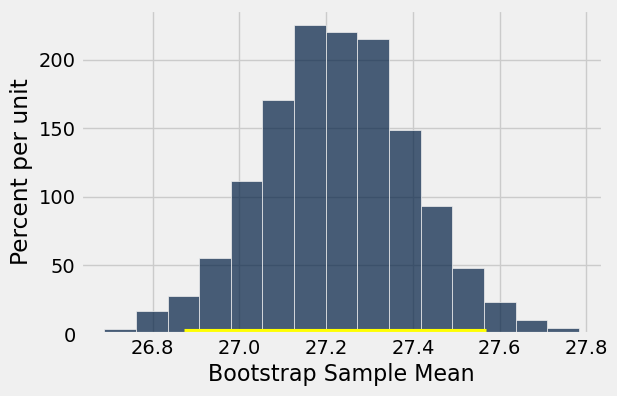

In [10]:
resampled_means = Table().with_columns(
    'Bootstrap Sample Mean', bstrap_means
)
resampled_means.hist(bins=15)
plots.plot([left, right], [0, 0], color='yellow', lw=8);

### Method 2: Central Limit Theorem

In [12]:
sampled_ages = births.column('Maternal Age')
sample_size = len(sampled_ages)
sample_average = np.average(sampled_ages)
sample_SD = np.std(sampled_ages)

print(f"Sample Size: {sample_size}")
print(f"Sample Average: {sample_average}")
print(f"Sample SD: {sample_SD}")

Sample Size: 1174
Sample Average: 27.228279386712096
Sample SD: 5.815360404190897


We need to estimate the SD of the sample averaage. population is estimated with the sample.

In [14]:
estimated_SD_of_sample_average = sample_SD / (sample_size**0.5)
estimated_SD_of_sample_average

0.16972373742299796

In [17]:
sample_average - 2*estimated_SD_of_sample_average, sample_average + 2*estimated_SD_of_sample_average

(26.888831911866099, 27.567726861558093)

## Designing Experiments

### SD of 0/1 population

In [18]:
number_of_ones = 2
zero_one_population = np.append(np.ones(number_of_ones), np.zeros(10 - number_of_ones))

print('Standard Deviation:', np.round(np.std(zero_one_population),2))

zero_one_population

Standard Deviation: 0.4


array([ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [19]:
def sd_of_zero_one_population(number_of_ones):
    """Returns the SD of a population 
    that has 10 elements: num_ones with value 1 and (10 - num_ones) with value 0"""
    zero_one_population = np.append(np.ones(number_of_ones), 
                                    np.zeros(10 - number_of_ones))
    return np.std(zero_one_population)

In [20]:
possible_ones = np.arange(11)
zero_one_pop = Table().with_columns(
    'Number of Ones', possible_ones,
    'Proportion of Ones', possible_ones / 10
)
zero_one_pop.show()

Number of Ones,Proportion of Ones
0,0
1,0.1
2,0.2
3,0.3
4,0.4
5,0.5
6,0.6
7,0.7
8,0.8
9,0.9


In [21]:
sds = zero_one_pop.apply(sd_of_zero_one_population, 'Number of Ones')
zero_one_pop = zero_one_pop.with_column('Pop SD', sds)
zero_one_pop.show()

Number of Ones,Proportion of Ones,Pop SD
0,0,0
1,0.1,0.3
2,0.2,0.4
3,0.3,0.458258
4,0.4,0.489898
5,0.5,0.5
6,0.6,0.489898
7,0.7,0.458258
8,0.8,0.4
9,0.9,0.3


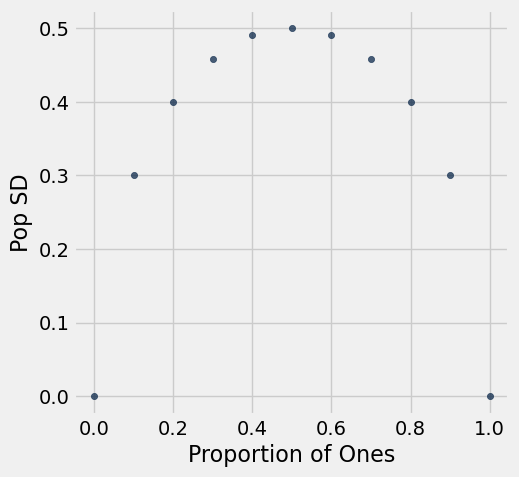

In [22]:
zero_one_pop.scatter('Proportion of Ones', 'Pop SD')

# Lecture 22 pt 2: Correlation

To bring us back to where we were before, let's explore the family heights data. This particular code should be review.

In [27]:
families = Table.read_table('family_heights.csv')
families.show(6)

family,father,mother,child,children,order,sex
1,78.5,67,73.2,4,1,male
1,78.5,67,69.2,4,2,female
1,78.5,67,69,4,3,female
1,78.5,67,69,4,4,female
2,75.5,66.5,73.5,4,1,male
2,75.5,66.5,72.5,4,2,male


Note: Child heights are the **adult** heights of children in a family

In [28]:
parent_avgs = (families.column('father') + families.column('mother'))/2
heights = Table().with_columns(
    'Parent Average', parent_avgs,
    'Child', families.column('child'),
)
heights.show(6)

Parent Average,Child
72.75,73.2
72.75,69.2
72.75,69
72.75,69
71,73.5
71,72.5


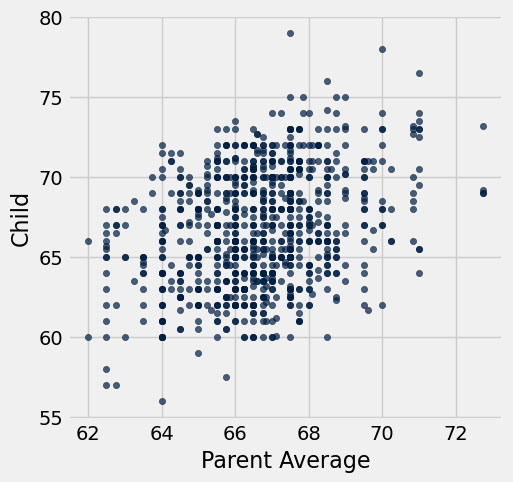

In [29]:
heights.scatter('Parent Average', 'Child')

In [30]:
nearby = heights.where('Parent Average', are.between(67.5, 68.5))
nearby_mean = np.average(nearby.column('Child'))
nearby_mean

67.620000000000005

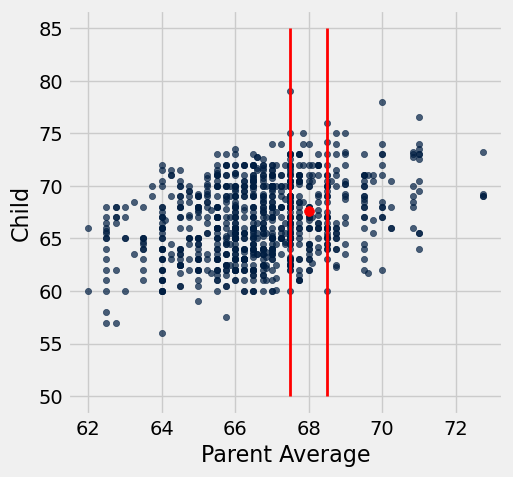

In [31]:
heights.scatter('Parent Average', 'Child')
plots.plot([67.5, 67.5], [50, 85], color='red', lw=2)
plots.plot([68.5, 68.5], [50, 85], color='red', lw=2)
plots.scatter(68, nearby_mean, color='red', s=50);

In [32]:
def predict_child(h):
    """Predict the height of a child whose parents have a parent average height of p_avg.
    
    The prediction is the average height of the children whose parent average height is
    in the range p_avg plus or minus 0.5.
    """
    nearby = heights.where('Parent Average', are.between(h - 1/2, h + 1/2))
    return np.average(nearby.column('Child'))

In [33]:
heights_with_predictions = heights.with_columns(
    'Prediction', heights.apply(predict_child, 'Parent Average'))

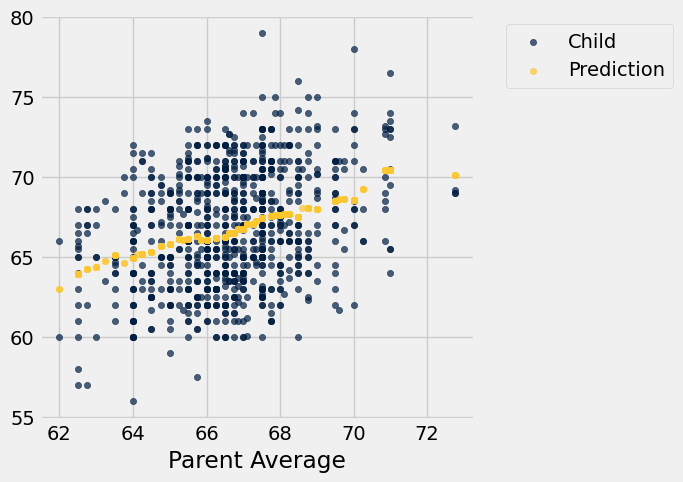

In [34]:
heights_with_predictions.scatter('Parent Average')

This prediction method (average y for a range of x) is called *regression.*

## Association

In [42]:
hybrid = Table.read_table('hybrid.csv')
hybrid.show(6)

vehicle,year,msrp,acceleration,mpg,class
Prius (1st Gen),1997,24509.7,7.46,41.26,Compact
Tino,2000,35355,8.2,54.1,Compact
Prius (2nd Gen),2000,26832.2,7.97,45.23,Compact
Insight,2000,18936.4,9.52,53,Two Seater
Civic (1st Gen),2001,25833.4,7.04,47.04,Compact
Insight,2001,19036.7,9.52,53,Two Seater


### Association between `mpg` and `msrp`; `acceleration` and `msrp`

In [39]:
hybrid.sort('msrp', descending=True).show(6)

vehicle,year,msrp,acceleration,mpg,class
Lexus LS600h/hL,2007,118544,17.54,21,Midsize
ActiveHybrid 7,2010,104300,20.41,22.11,Large
ActiveHybrid 7i,2011,102606,18.18,20,Midsize
ActiveHybrid X6,2009,97237.9,17.96,18.82,SUV
S400 Long,2009,96208.9,13.89,26.34,Large
Panamera S,2013,96150,18.52,25,Large


In [41]:
hybrid.sort('msrp').show(6)

vehicle,year,msrp,acceleration,mpg,class
A5 BSG,2009,11849.4,7.87,35.28,Midsize
Civic,2003,14071.9,8.62,41,Compact
Besturn B50,2010,14586.6,7.14,31.28,Midsize
Accord,2005,16343.7,14.93,28,Midsize
Fit Shuttle,2011,16394.4,7.52,58.8,Minivan
Fit/Jazz,2010,16911.8,8.26,30,Compact


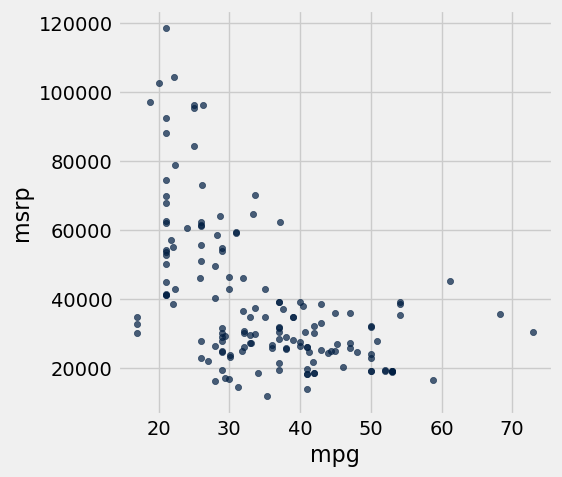

In [40]:
hybrid.scatter('mpg', 'msrp')

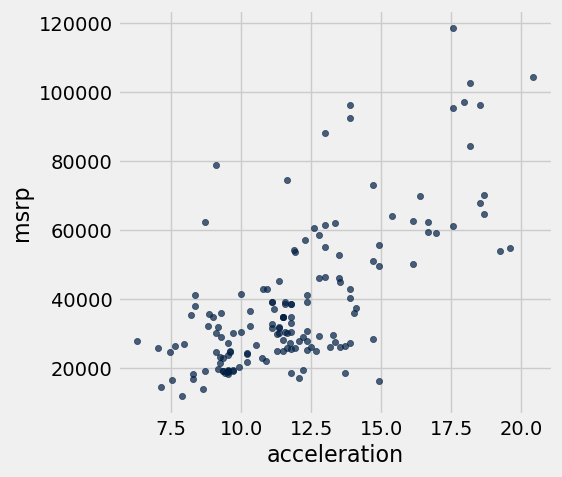

In [44]:
hybrid.scatter('acceleration', 'msrp')

#### Looking at the relationships just among SUVs

In [46]:
suv = hybrid.where('class', 'SUV')
suv.num_rows

39

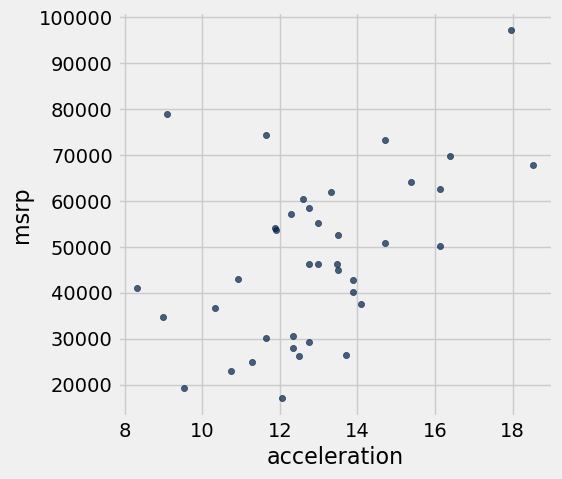

In [47]:
suv.scatter('acceleration', 'msrp')

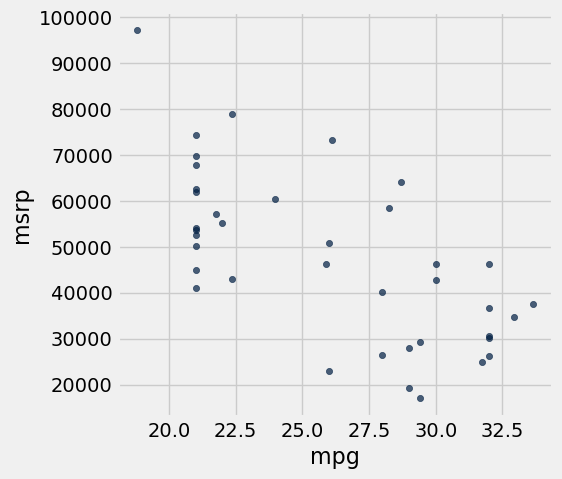

In [48]:
suv.scatter('mpg', 'msrp')

#### Comparing relationships in standard units

In [49]:
def standard_units(x):
    "Convert any array of numbers to standard units."
    return (x - np.average(x)) / np.std(x)

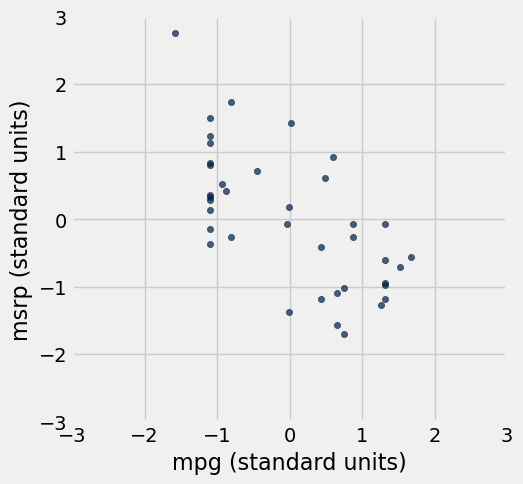

In [50]:
Table().with_columns(
    'mpg (standard units)',  standard_units(suv.column('mpg')), 
    'msrp (standard units)', standard_units(suv.column('msrp'))
).scatter(0, 1)
plots.xlim(-3, 3)
plots.ylim(-3, 3);

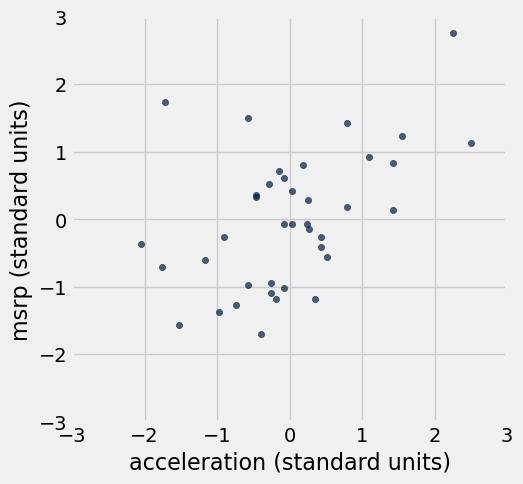

In [52]:
Table().with_columns(
    'acceleration (standard units)', standard_units(suv.column('acceleration')), 
    'msrp (standard units)',         standard_units(suv.column('msrp'))
).scatter(0, 1)
plots.xlim(-3, 3)
plots.ylim(-3, 3);

## Correlation

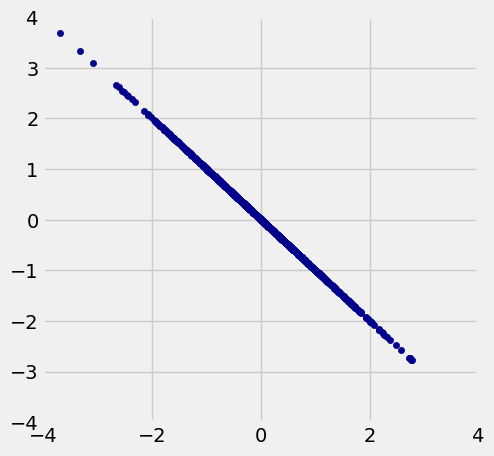

In [54]:
r_scatter(-1)

In [55]:
x = np.arange(1, 7, 1)
y = make_array(2, 3, 1, 5, 2, 7)
t = Table().with_columns(
        'x', x,
        'y', y
    )
t

x,y
1,2
2,3
3,1
4,5
5,2
6,7


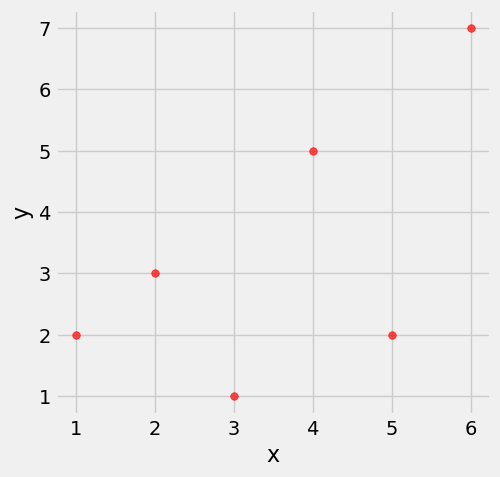

In [56]:
t.scatter('x', 'y', s=30, color='red')

Calculting the correlation coefficient by hand

In [58]:
t = t.with_columns(
        'x (standard units)', standard_units(x),
        'y (standard units)', standard_units(y)
    )
t

x,y,x (standard units),y (standard units)
1,2,-1.46385,-0.648886
2,3,-0.87831,-0.162221
3,1,-0.29277,-1.13555
4,5,0.29277,0.811107
5,2,0.87831,-0.648886
6,7,1.46385,1.78444


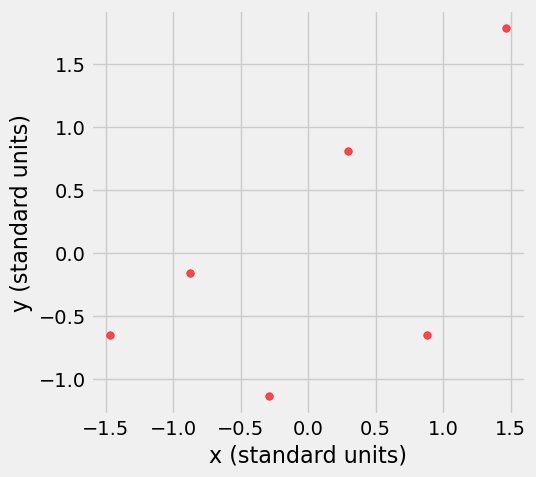

In [59]:
t.scatter(2, 3, s=30, color='red')

In [60]:
t = t.with_columns(
    'product of standard units', t.column(2) * t.column(3))
t

x,y,x (standard units),y (standard units),product of standard units
1,2,-1.46385,-0.648886,0.949871
2,3,-0.87831,-0.162221,0.142481
3,1,-0.29277,-1.13555,0.332455
4,5,0.29277,0.811107,0.237468
5,2,0.87831,-0.648886,-0.569923
6,7,1.46385,1.78444,2.61215


In [61]:
r = np.average(t.column(2) * t.column(3))
r

0.61741639718977093

Defining a function for $r$ based on our code:

In [62]:
def correlation(t, x, y):
    """t is a table; x and y are column labels"""
    x_in_standard_units = standard_units(t.column(x))
    y_in_standard_units = standard_units(t.column(y))
    return np.average(x_in_standard_units * y_in_standard_units)

In [63]:
correlation(t, 'x', 'y')

0.61741639718977093

In [64]:
correlation(suv, 'mpg', 'msrp')

-0.6667143635709919

In [65]:
correlation(suv, 'acceleration', 'msrp')

0.48699799279959155

Switching the order reflects things around $y=x$ but does not change the value of $r$.

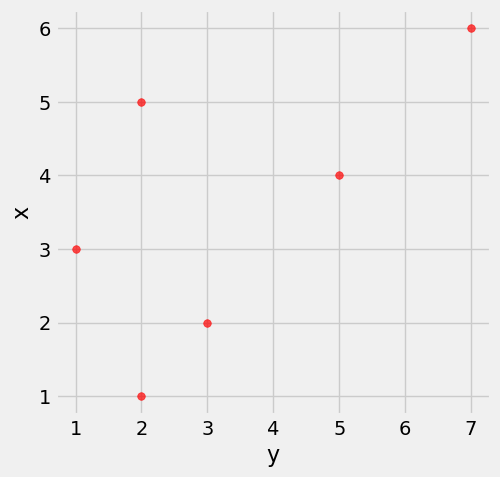

In [66]:
t.scatter('y', 'x', s=30, color='red')

In [67]:
correlation(t, 'y', 'x')

0.61741639718977093

$r$ only takes into account *linear* association.

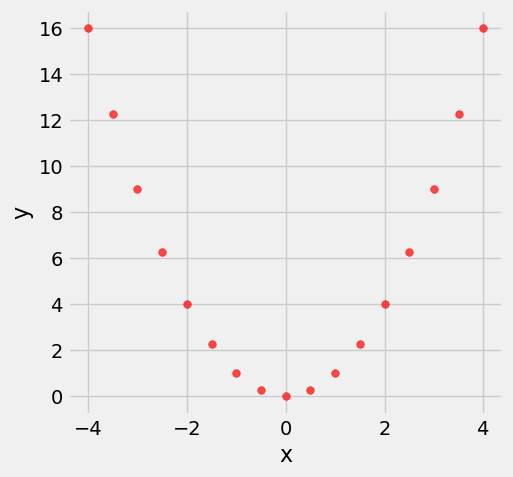

In [68]:
new_x = np.arange(-4, 4.1, 0.5)
nonlinear = Table().with_columns(
        'x', new_x,
        'y', new_x**2
    )
nonlinear.scatter('x', 'y', s=30, color='r')

In [69]:
correlation(nonlinear, 'x', 'y')

0.0

$r$ does not react well to outliers.

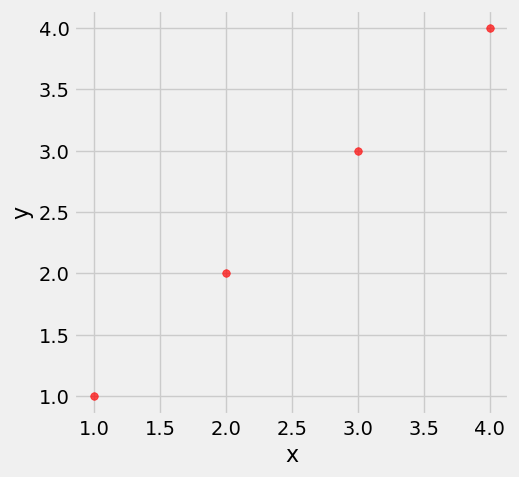

In [70]:
line = Table().with_columns(
        'x', make_array(1, 2, 3, 4),
        'y', make_array(1, 2, 3, 4)
    )
line.scatter('x', 'y', s=30, color='r')

In [71]:
correlation(line, 'x', 'y')

1.0

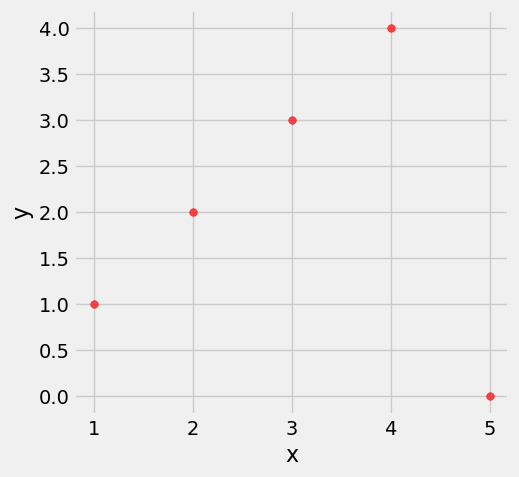

In [72]:
outlier = Table().with_columns(
        'x', make_array(1, 2, 3, 4, 5),
        'y', make_array(1, 2, 3, 4, 0)
    )
outlier.scatter('x', 'y', s=30, color='r')

In [73]:
correlation(outlier, 'x', 'y')

0.0

## Ecological Correlations

**Making conclusions with aggregated data means that the conclusion must be about the aggregate, not the individual.**

In [75]:
sat2014 = Table.read_table('sat_scores.csv').sort('State')
sat2014

State,Participation Rate,Critical Reading,Math,Writing,Combined
Alabama,6.7,547,538,532,1617
Alaska,54.2,507,503,475,1485
Arizona,36.4,522,525,500,1547
Arkansas,4.2,573,571,554,1698
California,60.3,498,510,496,1504
Colorado,14.3,582,586,567,1735
Connecticut,88.4,507,510,508,1525
Delaware,100,456,459,444,1359
District of Columbia,100,440,438,431,1309
Florida,72.2,491,485,472,1448


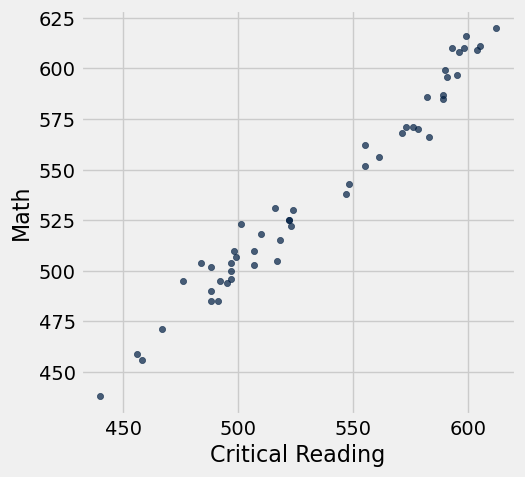

In [76]:
sat2014.scatter('Critical Reading', 'Math')

In [77]:
correlation(sat2014, 'Critical Reading', 'Math')

0.98475584110674341

One important thing to note is that the individual in this data set is a state, *not a person.*

In [86]:
def rate_code(x):
    if x <= 25:
        return 'low'
    elif x <= 50:
        return 'low-moderate'
    elif x <= 75:
        return 'moderate_high'
    else:
        return 'high'

In [87]:
rate_codes = sat2014.apply(rate_code, 'Participation Rate')
rate_codes

array(['low', 'moderate_high', 'low-moderate', 'low', 'moderate_high',
       'low', 'high', 'high', 'high', 'moderate_high', 'high',
       'moderate_high', 'high', 'low', 'moderate_high', 'low', 'low',
       'low', 'low', 'high', 'high', 'high', 'low', 'low', 'low', 'low',
       'low', 'low', 'moderate_high', 'moderate_high', 'high', 'low',
       'high', 'moderate_high', 'low', 'low', 'low', 'low-moderate',
       'moderate_high', 'moderate_high', 'moderate_high', 'low', 'low',
       'moderate_high', 'low', 'moderate_high', 'moderate_high',
       'moderate_high', 'low', 'low', 'low'],
      dtype='<U13')

In [88]:
sat2014 = sat2014.with_columns('Rate Code', rate_codes)
sat2014.show(6)

State,Participation Rate,Critical Reading,Math,Writing,Combined,Rate Code
Alabama,6.7,547,538,532,1617,low
Alaska,54.2,507,503,475,1485,moderate_high
Arizona,36.4,522,525,500,1547,low-moderate
Arkansas,4.2,573,571,554,1698,low
California,60.3,498,510,496,1504,moderate_high
Colorado,14.3,582,586,567,1735,low


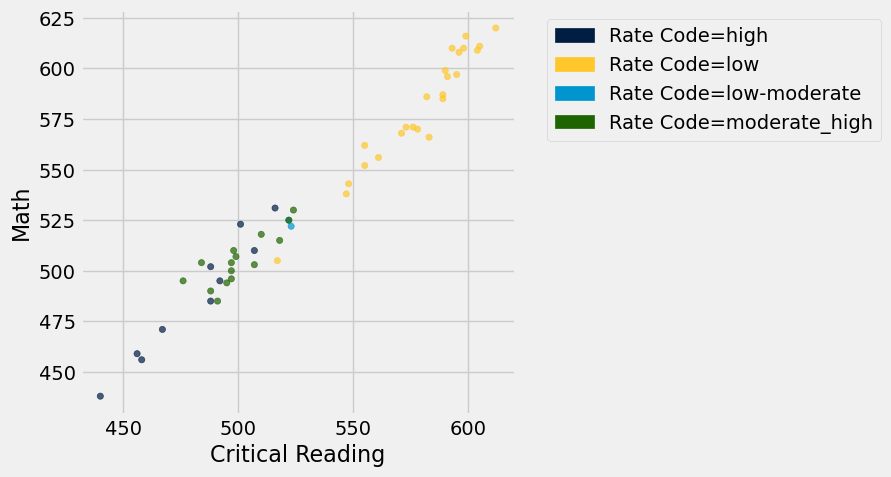

In [89]:
sat2014.scatter('Critical Reading', 'Math', group='Rate Code')

In [90]:
sat2014.where('Rate Code', 'low').show()

State,Participation Rate,Critical Reading,Math,Writing,Combined,Rate Code
Alabama,6.7,547,538,532,1617,low
Arkansas,4.2,573,571,554,1698,low
Colorado,14.3,582,586,567,1735,low
Illinois,4.6,599,616,587,1802,low
Iowa,3.1,605,611,578,1794,low
Kansas,5.3,591,596,566,1753,low
Kentucky,4.6,589,585,572,1746,low
Louisiana,4.6,561,556,550,1667,low
Michigan,3.8,593,610,581,1784,low
Minnesota,5.9,598,610,578,1786,low


In [92]:
sat2014.where('Rate Code', 'high').show()

State,Participation Rate,Critical Reading,Math,Writing,Combined,Rate Code
Connecticut,88.4,507,510,508,1525,high
Delaware,100,456,459,444,1359,high
District of Columbia,100,440,438,431,1309,high
Georgia,77.2,488,485,472,1445,high
Idaho,100,458,456,450,1364,high
Maine,95.6,467,471,449,1387,high
Maryland,78.5,492,495,481,1468,high
Massachusetts,84.1,516,531,509,1556,high
New Jersey,79.3,501,523,502,1526,high
New York,76.3,488,502,478,1468,high
